Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,241 (290.00 KB)

 Trainable params: 74,241 (290.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 91s 94ms/step - accuracy: 0.9512 - loss: 0.1380 - val_accuracy: 0.9895 - val_loss: 0.0256
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.9899 - loss: 0.0246 - val_accuracy: 0.9913 - val_loss: 0.0212
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - accuracy: 0.9916 - loss: 0.0205 - val_accuracy: 0.9922 - val_loss: 0.0189
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 138s 90ms/step - accuracy: 0.9927 - loss: 0.0179 - val_accuracy: 0.9934 - val_loss: 0.0162
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.9935 - loss: 0.0159 - val_accuracy: 0.9941 - val_loss: 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


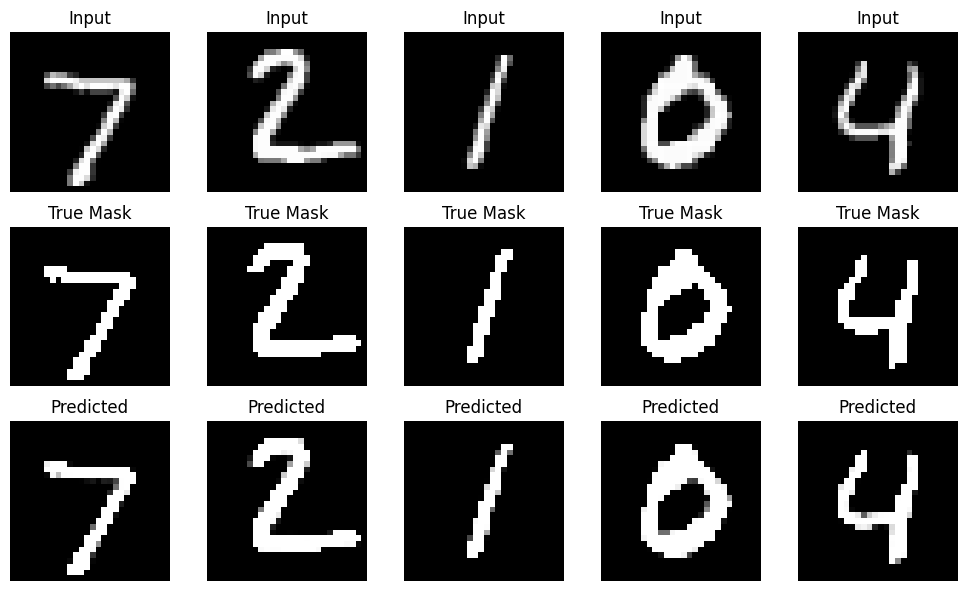

In [12]:
# ===========================================
# 🧠 CNN Segmentation on MNIST
# ===========================================
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and preprocess MNIST
# -------------------------------
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [0,1] and expand channel dimension
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test = tf.expand_dims(x_test, axis=-1)    # (10000, 28, 28, 1)

# For segmentation, our "mask" is just the digit itself
y_train = tf.cast(x_train > 0.3, tf.float32)
y_test = tf.cast(x_test > 0.3, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

# -------------------------------
# 2. CNN segmentation model
# -------------------------------
inputs = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)   # 14x14
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)   # 7x7

# Decoder
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)  # 14x14
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)  # 28x28
outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# -------------------------------
# 3. Train model
# -------------------------------
history = model.fit(train_ds, validation_data=test_ds, epochs=5)

# -------------------------------
# 4. Visualize predictions
# -------------------------------
sample_img, sample_mask = next(iter(test_ds))
pred_mask = model.predict(sample_img)

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_img[i].numpy().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis("off")

    plt.subplot(3, 5, i + 6)
    plt.imshow(sample_mask[i].numpy().squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(3, 5, i + 11)
    plt.imshow(pred_mask[i].squeeze(), cmap='gray')
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()